**13-02 LSTM을 이용한 네이버 영화 리뷰 분류**

In [ ]:
!pip install konlpy
!pip install mecab-python
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [25]:
pip install JPype1

In [ ]:
pip install mecab-python3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.7/581.7 kB 2.4 MB/s eta 0:00:00


In [30]:
#import
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Mecab
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter

In [3]:
#데이터 로드하기
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7d01238d71f0>)

In [4]:
#데이터 분류
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

#훈련용 리뷰 개수
print(len(train_data))

150000


In [5]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [6]:
#테스트용 리뷰 개수
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [7]:
#데이터 정제하기
#훈련데이터 전처리
#중복 확인
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [8]:
#중복 제거
train_data.drop_duplicates(subset=['document'], inplace = True)

In [9]:
len(train_data)

146183

<Axes: >

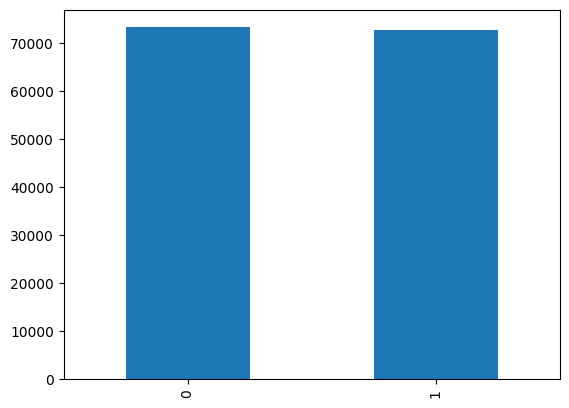

In [10]:
#값의 분포 확인
train_data['label'].value_counts().plot(kind = 'bar')

In [11]:
print(train_data.groupby('label').size().reset_index(name='count'))

   label  count
0      0  73342
1      1  72841


In [12]:
#null값 확인
print(train_data.isnull().values.any())

True


In [13]:
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [14]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [15]:
train_data = train_data.dropna(how = 'any')
print(train_data.isnull().values.any())

False


In [16]:
print(len(train_data))

146182


In [17]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

<ipython-input-17-4419b0600db1>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [18]:
# 한글과 공백이 없으면 리뷰가 빈 값이 될것이므로 빈값이 있는지 확인
train_data['document'] = train_data['document'].str.replace('^ +',"")
train_data['document'].replace('',np.nan,inplace = True)
print(train_data.isnull().sum())

<ipython-input-18-4888c8b24eea>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +',"")


id            0
document    789
label         0
dtype: int64


In [19]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145393


In [20]:
#테스트 데이터 전처리
test_data.drop_duplicates(subset = ['document'], inplace = True)
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]","")
test_data['document'] = test_data['document'].str.replace('^ +',"")
test_data['document'].replace('',np.nan,inplace=True)
test_data = test_data.dropna(how='any')
print(len(test_data))

<ipython-input-20-f0087ec6345e>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]","")


48852


<ipython-input-20-f0087ec6345e>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +',"")


In [ ]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash
!pip install python-mecab-ko

In [31]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한',
             '에', '하', '고', '을', '를', '인', '듯', '과',
             '와', '네', '들', '듯', '지', '임', '게']

mecab = Mecab()

X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = mecab.Mecab(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

Exception: Install MeCab in order to use it: http://konlpy.org/en/latest/install/

In [24]:
#토큰화

#불용어 제거
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한',
             '에', '하', '고', '을', '를', '인', '듯', '과',
             '와', '네', '들', '듯', '지', '임', '게']

mecab = Mecab()

X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = mecab.morphs(sentence)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
    X_train.append(stopwords_removed_sentence)

Exception: Install MeCab in order to use it: http://konlpy.org/en/latest/install/